# DDPM CIFAR-10 Training

batch=256, steps=500k

In [1]:
import os, subprocess
result = subprocess.run(['cat', '/proc/self/status'], capture_output=True, text=True)
for line in result.stdout.split('\n'):
    if 'Cpus_allowed_list' in line:
        cpus = line.split(':')[1].strip()
        break
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['MKL_NUM_THREADS'] = '16'
os.system(f'taskset -cp {cpus} {os.getpid()} 2>/dev/null')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from pytorch_fid.fid_score import calculate_fid_given_paths
import os

torch.set_num_threads(16)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device('cuda')
print(f'CPUs: {cpus}')
print(f'GPU: {torch.cuda.get_device_name(0)}')

pid 3297's current affinity list: 28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58
pid 3297's new affinity list: 28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58
CPUs: 28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58
GPU: NVIDIA H100 80GB HBM3


In [2]:
# Config
T = 1000
beta_start, beta_end = 0.0001, 0.02
base_ch = 96
ch_mult = (1, 2, 3, 4)
attn_res = (8, 16)
num_res = 2
batch_size = 256
lr = 1e-4
total_steps = 500_000
warmup = 2000
grad_clip = 0.5
ema_decay = 0.9999
num_workers = 4

for d in ['checkpoints', 'samples', 'results']:
    Path(d).mkdir(exist_ok=True)

print(f'Batch={batch_size}, Steps={total_steps:,}, LR={lr}')

Batch=256, Steps=500,000, LR=0.0001


In [3]:
# Data
tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,)*3, (0.5,)*3)])
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=tfm)
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=num_workers, 
                         pin_memory=True, drop_last=True, persistent_workers=True, prefetch_factor=4)
print(f'Samples={len(train_data):,}, Batches={len(train_loader):,}')

Files already downloaded and verified
Samples=50,000, Batches=195


In [ ]:
# Schedule
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0)
alphas_bar_prev = F.pad(alphas_bar[:-1], (1,0), value=1.0)
sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_1m_alphas_bar = torch.sqrt(1 - alphas_bar)
sqrt_recip_alphas = torch.sqrt(1 / alphas)
post_var = betas * (1 - alphas_bar_prev) / (1 - alphas_bar)
post_coef1 = betas * torch.sqrt(alphas_bar_prev) / (1 - alphas_bar)
post_coef2 = (1 - alphas_bar_prev) * torch.sqrt(alphas) / (1 - alphas_bar)

def extract(a, t, shape):
    return a.gather(-1, t).reshape(t.shape[0], *((1,)*(len(shape)-1)))

In [5]:
# Model
class TimeEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        emb = np.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], -1)

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_ch, drop=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time = nn.Linear(t_ch, out_ch)
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.drop = nn.Dropout(drop)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x, t):
        h = F.silu(self.norm1(x))
        h = self.conv1(h)
        h = h + self.time(F.silu(t))[:,:,None,None]
        h = F.silu(self.norm2(h))
        h = self.drop(h)
        h = self.conv2(h)
        return h + self.skip(x)

class Attn(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.norm = nn.GroupNorm(8, ch)
        self.attn = nn.MultiheadAttention(ch, 4, batch_first=True)
    def forward(self, x):
        b, c, h, w = x.shape
        res = x
        x = self.norm(x).reshape(b, c, h*w).permute(0, 2, 1)
        x, _ = self.attn(x, x, x)
        return x.permute(0, 2, 1).reshape(b, c, h, w) + res

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        t_dim = base_ch * 4
        self.t_mlp = nn.Sequential(TimeEmb(base_ch), nn.Linear(base_ch, t_dim), nn.SiLU(), nn.Linear(t_dim, t_dim))
        self.conv_in = nn.Conv2d(3, base_ch, 3, padding=1)
        
        # Encoder
        self.downs = nn.ModuleList()
        self.skip_chs = [base_ch]
        ch = base_ch
        res = 32
        for i, mult in enumerate(ch_mult):
            out = base_ch * mult
            for _ in range(num_res):
                layers = [ResBlock(ch, out, t_dim, 0.1)]
                ch = out
                if res in attn_res:
                    layers.append(Attn(ch))
                self.downs.append(nn.ModuleList(layers))
                self.skip_chs.append(ch)
            if i < len(ch_mult) - 1:
                self.downs.append(nn.ModuleList([nn.Conv2d(ch, ch, 3, 2, 1)]))
                self.skip_chs.append(ch)
                res //= 2
        
        # Mid
        self.mid1 = ResBlock(ch, ch, t_dim, 0.1)
        self.mid_attn = Attn(ch)
        self.mid2 = ResBlock(ch, ch, t_dim, 0.1)
        
        # Decoder
        self.ups = nn.ModuleList()
        for i, mult in enumerate(reversed(ch_mult)):
            out = base_ch * mult
            for j in range(num_res + 1):
                skip = self.skip_chs.pop()
                layers = [ResBlock(ch + skip, out, t_dim, 0.1)]
                ch = out
                if res in attn_res:
                    layers.append(Attn(ch))
                if i < len(ch_mult) - 1 and j == num_res:
                    layers.append(nn.Sequential(nn.Upsample(scale_factor=2), nn.Conv2d(ch, ch, 3, padding=1)))
                    res *= 2
                self.ups.append(nn.ModuleList(layers))
        
        self.out = nn.Sequential(nn.GroupNorm(8, base_ch), nn.SiLU(), nn.Conv2d(base_ch, 3, 3, padding=1))
    
    def forward(self, x, t):
        t = self.t_mlp(t)
        h = self.conv_in(x)
        skips = [h]
        for mods in self.downs:
            for m in mods:
                h = m(h, t) if isinstance(m, ResBlock) else m(h)
            skips.append(h)
        h = self.mid1(h, t)
        h = self.mid_attn(h)
        h = self.mid2(h, t)
        for mods in self.ups:
            h = torch.cat([h, skips.pop()], 1)
            for m in mods:
                h = m(h, t) if isinstance(m, ResBlock) else m(h)
        return self.out(h)

model = UNet().to(device)
print(f'Params: {sum(p.numel() for p in model.parameters()):,}')

Params: 47,424,099


In [ ]:
# Train funcs
def q_sample(x0, t, noise=None):
    if noise is None: noise = torch.randn_like(x0)
    return extract(sqrt_alphas_bar, t, x0.shape) * x0 + extract(sqrt_1m_alphas_bar, t, x0.shape) * noise

def loss_fn(model, x0, t):
    noise = torch.randn_like(x0)
    return F.mse_loss(model(q_sample(x0, t, noise), t), noise)

class EMA:
    def __init__(self, model, decay=0.9999):
        self.model = model
        self.decay = decay
        self.shadow = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
    def update(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1-self.decay)
    def apply(self):
        self.backup = {n: p.clone() for n, p in self.model.named_parameters()}
        for n, p in self.model.named_parameters():
            if n in self.shadow: p.data.copy_(self.shadow[n])
    def restore(self):
        for n, p in self.model.named_parameters():
            if n in self.backup: p.data.copy_(self.backup[n])

In [7]:
# Sample
@torch.no_grad()
def p_sample(model, x, t, t_idx):
    noise = model(x, t)
    beta = extract(betas, t, x.shape)
    sqrt_1m_ab = extract(sqrt_1m_alphas_bar, t, x.shape)
    sqrt_recip = extract(sqrt_recip_alphas, t, x.shape)
    x0 = torch.clamp(sqrt_recip * (x - sqrt_1m_ab * noise), -1, 1)
    c1 = extract(post_coef1, t, x.shape)
    c2 = extract(post_coef2, t, x.shape)
    mean = c1 * x0 + c2 * x
    if t_idx == 0: return mean
    return mean + torch.sqrt(extract(post_var, t, x.shape)) * torch.randn_like(x)

@torch.no_grad()
def sample(model, n=64):
    model.eval()
    x = torch.randn(n, 3, 32, 32).to(device)
    for i in tqdm(reversed(range(T)), total=T):
        x = p_sample(model, x, torch.full((n,), i, device=device, dtype=torch.long), i)
    return x

print('Ready')

Ready


In [8]:
# Setup
opt = Adam(model.parameters(), lr=lr, fused=True)
ema = EMA(model, ema_decay)
step = 0
losses = []
best = float('inf')
ckpt_path = Path('checkpoints/auto.pt')

if ckpt_path.exists():
    c = torch.load(ckpt_path)
    model.load_state_dict(c['model'])
    opt.load_state_dict(c['opt'])
    ema.shadow = c['ema']
    step = c['step']
    losses = c['losses'][:step]
    best = c['best']
    print(f'Resume: step {step:,}')
else:
    print('Start fresh')

print(f'{step:,} / {total_steps:,}')

/local_scratch/slurm.7596693/ipykernel_3297/1469901562.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  c = torch.load(ckpt_path)


Resume: step 500,000
500,000 / 500,000


In [9]:
# Train
model.train()
def gen(): 
    while True:
        for b in train_loader: yield b
data = gen()
bar = tqdm(initial=step, total=total_steps)

while step < total_steps:
    imgs, _ = next(data)
    imgs = imgs.to(device)
    t = torch.randint(0, T, (imgs.shape[0],), device=device).long()
    if step < warmup:
        for g in opt.param_groups: g['lr'] = lr * step / warmup
    loss = loss_fn(model, imgs, t)
    opt.zero_grad()
    loss.backward()
    gn = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    opt.step()
    ema.update()
    losses.append(loss.item())
    best = min(best, loss.item())
    step += 1
    bar.set_postfix({'loss': f'{loss.item():.4f}', 'gn': f'{gn:.2f}'})
    bar.update()
    if step % 5000 == 0:
        torch.save({'step':step, 'model':model.state_dict(), 'opt':opt.state_dict(), 
                   'ema':ema.shadow, 'losses':losses, 'best':best}, ckpt_path)
    if step % 10000 == 0:
        print(f'\nSample @ {step:,}')
        ema.apply()
        s = sample(model, 64)
        ema.restore()
        save_image(s, f'samples/{step:07d}.png', nrow=8, normalize=True, value_range=(-1,1))
        model.train()
    if step % 25000 == 0:
        torch.save({'step':step, 'model':model.state_dict(), 'opt':opt.state_dict(),
                   'ema':ema.shadow, 'losses':losses, 'best':best}, f'checkpoints/{step:07d}.pt')

bar.close()
print('Done!')

100%|██████████| 500000/500000 [00:00<?, ?it/s]

Done!


In [10]:
# Save
ema.apply()
torch.save({'step':step, 'model':model.state_dict(), 'ema':ema.shadow, 'losses':losses, 'best':best}, 
          'results/final.pt')
ema.restore()
print('Saved')

Saved


100%|██████████| 1000/1000 [00:10<00:00, 93.35it/s]


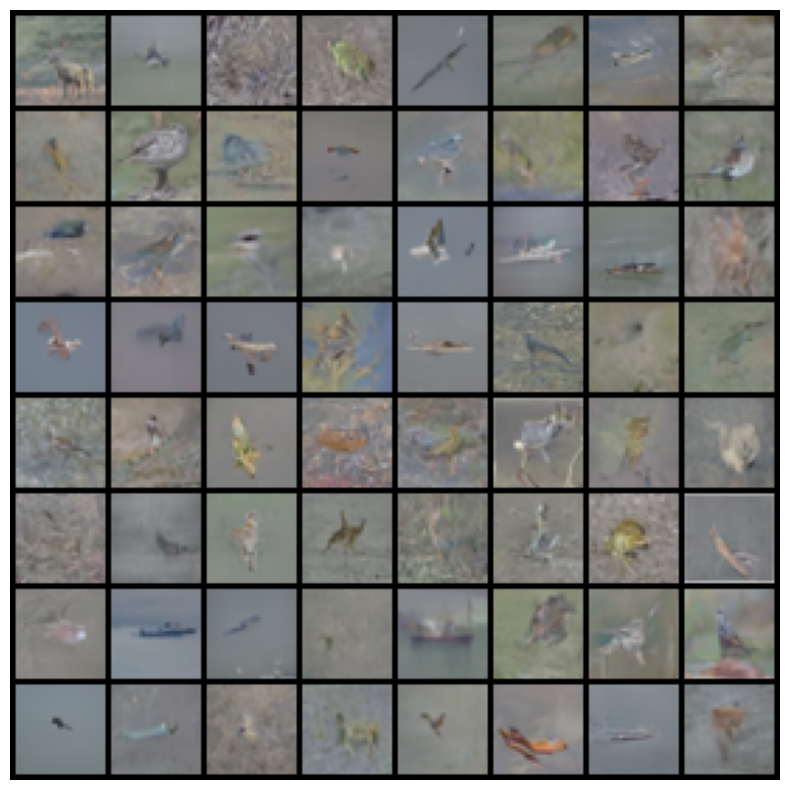

In [11]:
# Final samples
ema.apply()
imgs = sample(model, 64)
ema.restore()
save_image(imgs, 'results/final.png', nrow=8, normalize=True, value_range=(-1,1))
grid = make_grid(imgs, nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(10,10))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis('off')
plt.show()

In [12]:
ema.apply()
samples = torch.cat([sample(model, 64) for _ in tqdm(range(157))], 0)[:10000]
ema.restore()

os.makedirs('fid_gen', exist_ok=True)
os.makedirs('fid_real', exist_ok=True)

for i, img in enumerate(samples):
    save_image(img, f'fid_gen/{i:05d}.png', normalize=True, value_range=(-1,1))

test = datasets.CIFAR10('./data', train=False, transform=tfm)
for i in range(10000):
    save_image(test[i][0], f'fid_real/{i:05d}.png', normalize=True, value_range=(-1,1))

fid = calculate_fid_given_paths(['fid_real', 'fid_gen'], 64, device, 2048)
print(f'FID: {fid:.2f}')

 72%|███████▏  | 723/1000 [00:07<00:02, 97.12it/s]
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 157/157 [00:07<00:00, 20.89it/s]


FID: 87.46


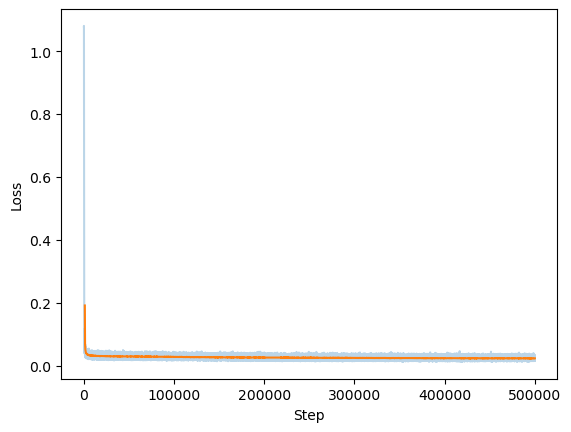

In [13]:
# Plot
plt.figure()
plt.plot(losses, alpha=0.3)
if len(losses) > 1000:
    w = 1000
    s = np.convolve(losses, np.ones(w)/w, mode='valid')
    plt.plot(range(w-1, len(losses)), s)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [14]:
# Summary
print('='*50)
print(f'Steps: {step:,}')
print(f'Loss: {np.mean(losses[-100:]):.4f}')
print(f'Best: {best:.4f}')
print('='*50)

Steps: 500,000
Loss: 0.0235
Best: 0.0118


/local_scratch/slurm.7613177/ipykernel_317496/2713751340.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('checkpoints/auto.pt', map_location='cpu')


Loaded: 500,000 loss values
Steps: 500,000
Final loss: 0.0235
Best loss: 0.0118


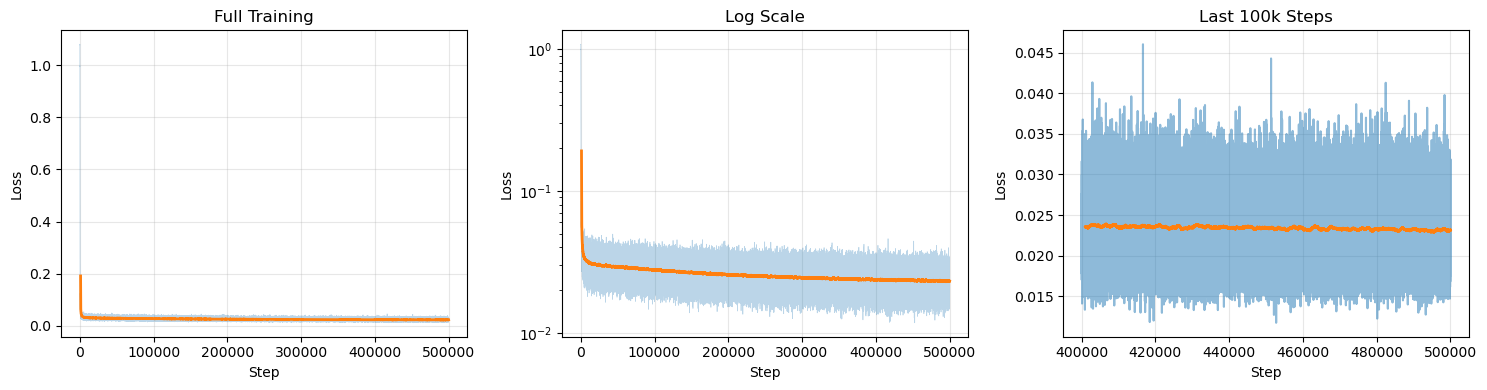

In [2]:
from pathlib import Path

# Load checkpoint
ckpt = torch.load('checkpoints/auto.pt', map_location='cpu')
losses = ckpt['losses']
step = ckpt['step']
best = ckpt['best']

print(f"Loaded: {len(losses):,} loss values")
print(f"Steps: {step:,}")
print(f"Final loss: {np.mean(losses[-100:]):.4f}")
print(f"Best loss: {best:.4f}")

# Now run the plotting code
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(losses, alpha=0.3, linewidth=0.5)
w = 1000
s = np.convolve(losses, np.ones(w)/w, mode='valid')
plt.plot(range(w-1, len(losses)), s, linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Full Training')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(losses, alpha=0.3, linewidth=0.5)
plt.plot(range(w-1, len(losses)), s, linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Log Scale')
plt.yscale('log')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
start = max(0, len(losses) - 100000)
plt.plot(range(start, len(losses)), losses[start:], alpha=0.5)
s2 = np.convolve(losses[start:], np.ones(w)/w, mode='valid')
plt.plot(range(start+w-1, len(losses)), s2, linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Last 100k Steps')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()